# Phase 5 - Protein Language Model Embeddings

## 🎯 Goal
Use **pre-trained Protein Language Models (PLMs)** to generate sequence embeddings and classify GPCR subfamilies.

## 🧬 Why Protein Language Models?

Traditional methods (Phase 3):
- ❌ Rely on sequence identity (misses functional similarity)
- ❌ Don't capture evolutionary context
- ❌ Ignore structural/functional properties

**Protein Language Models**:
- ✅ Trained on millions of protein sequences
- ✅ Learn evolutionary patterns, structure, function
- ✅ Generate rich embeddings (vectors) for each protein
- ✅ State-of-the-art for protein classification

## 📚 Models We'll Use:

1. **ESM-2** (Meta/Facebook AI) - Best performance for protein tasks
2. **ProtBERT** (Alternative - BERT for proteins)

## 📊 Pipeline:

1. Load pre-trained model
2. Generate embeddings for all sequences
3. Extract features (pooling strategies)
4. Train classifier (Random Forest, SVM, Neural Net)
5. Evaluate performance
6. Compare with Phase 3 (sequence identity)

---


## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Check if torch is installed
try:
    import torch
    print(f"✅ PyTorch installed: {torch.__version__}")
    print(f"   CUDA available: {torch.cuda.is_available()}")
except ImportError:
    print("⚠️ PyTorch not installed")
    print("   Install: pip install torch")

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✅ Libraries imported")

✅ PyTorch installed: 2.10.0+cpu
   CUDA available: False

✅ Libraries imported


## 2. Install ESM-2 (if needed)

ESM-2 is Meta's state-of-the-art protein language model.

In [2]:
# Install ESM if not already installed
try:
    import esm
    print("✅ ESM already installed")
except ImportError:
    print("📦 Installing ESM-2...")
    !pip install fair-esm
    import esm
    print("✅ ESM installed")

✅ ESM already installed


## 3. Load Data

In [8]:
print("="*80)
print("LOADING DATA")
print("="*80)

# Load sequences with subfamily labels
df = pd.read_csv("../data/processed/phase3_all_sequences_with_similarity.csv")

print(f"\nTotal sequences: {len(df)}")
print(f"\nSubfamily distribution:")
print(df['subfamily'].value_counts())

# Filter: Only sequences with subfamily labels
df_labeled = df[df['subfamily'].notna()].copy()

print(f"\n✅ Labeled sequences: {len(df_labeled)}")
print(f"\nBreakdown:")
for subfamily in df_labeled['subfamily'].unique():
    count = len(df_labeled[df_labeled['subfamily'] == subfamily])
    print(f"  {subfamily}: {count}")

# Sample for faster testing (remove this for full run)
print("\n⚠️ Sampling 100 sequences per subfamily for faster testing")
print("   (Remove this cell for full dataset)")

sampled_groups = []
for subfamily, group in df_labeled.groupby('subfamily'):
    n_sample = min(100, len(group))
    sampled = group.sample(n=n_sample, random_state=42)
    sampled_groups.append(sampled)

df_sampled = pd.concat(sampled_groups, ignore_index=True)


print(f"\n📊 Working with {len(df_sampled)} sequences")
print(df_sampled['subfamily'].value_counts())

LOADING DATA

Total sequences: 1908

Subfamily distribution:
subfamily
Adrenergic_beta     372
Adrenergic_alpha     53
Name: count, dtype: int64

✅ Labeled sequences: 425

Breakdown:
  Adrenergic_beta: 372
  Adrenergic_alpha: 53

⚠️ Sampling 100 sequences per subfamily for faster testing
   (Remove this cell for full dataset)

📊 Working with 153 sequences
subfamily
Adrenergic_beta     100
Adrenergic_alpha     53
Name: count, dtype: int64


## 4. Load ESM-2 Model

We'll use **ESM-2 (650M parameters)** - good balance of performance and speed.

Model options:
- `esm2_t33_650M_UR50D` - 650M params (recommended)
- `esm2_t30_150M_UR50D` - 150M params (faster)
- `esm2_t36_3B_UR50D` - 3B params (best, but slow)

In [5]:
print("="*80)
print("LOADING ESM-2 MODEL")
print("="*80)

import torch
import esm

# Load model
print("\n📥 Loading ESM-2 (650M)...")
print("   (First time will download ~2.5 GB)")

model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()  # Disable dropout for inference

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

print(f"\n✅ Model loaded")
print(f"   Device: {device}")
print(f"   Embedding dimension: {model.embed_dim}")
print(f"   Number of layers: {model.num_layers}")

LOADING ESM-2 MODEL

📥 Loading ESM-2 (650M)...
   (First time will download ~2.5 GB)
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t33_650M_UR50D.pt" to C:\Users\Ahmed Tarek/.cache\torch\hub\checkpoints\esm2_t33_650M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t33_650M_UR50D-contact-regression.pt" to C:\Users\Ahmed Tarek/.cache\torch\hub\checkpoints\esm2_t33_650M_UR50D-contact-regression.pt

✅ Model loaded
   Device: cpu
   Embedding dimension: 1280
   Number of layers: 33


## 5. Generate Embeddings

We'll extract embeddings using the model's representation layer.

**Pooling strategies**:
- **Mean pooling**: Average of all token embeddings
- **CLS token**: Use the special [CLS] token (like BERT)
- **Max pooling**: Max value across all positions

In [9]:
print("="*80)
print("GENERATING EMBEDDINGS")
print("="*80)

def get_embedding(sequence, model, batch_converter, device):
    """
    Generate embedding for a single sequence
    """
    # Prepare data
    data = [('protein', sequence)]
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    batch_tokens = batch_tokens.to(device)
    
    # Get embeddings
    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33])  # Last layer
        embeddings = results['representations'][33]
    
    # Mean pooling (excluding start/end tokens)
    embedding = embeddings[0, 1:-1].mean(dim=0)
    
    return embedding.cpu().numpy()

# Generate embeddings for all sequences
print(f"\n🔄 Processing {len(df_sampled)} sequences...")
print("   (This may take a few minutes)\n")

embeddings = []
failed = 0

for idx, row in df_sampled.iterrows():
    try:
        # Truncate if too long (ESM-2 max is 1024)
        seq = row['sequence'][:1022]
        
        embedding = get_embedding(seq, model, batch_converter, device)
        embeddings.append(embedding)
        
        if (idx + 1) % 20 == 0:
            print(f"  Processed {idx + 1}/{len(df_sampled)} sequences")
    
    except Exception as e:
        print(f"  ⚠️ Failed for sequence {idx}: {e}")
        embeddings.append(np.zeros(model.embed_dim))
        failed += 1

# Convert to array
embeddings_array = np.array(embeddings)

print(f"\n✅ Generated embeddings")
print(f"   Shape: {embeddings_array.shape}")
print(f"   Failed: {failed}/{len(df_sampled)}")

# Add to dataframe
df_sampled['embedding'] = list(embeddings_array)

GENERATING EMBEDDINGS

🔄 Processing 153 sequences...
   (This may take a few minutes)

  ⚠️ Failed for sequence 0: 'teksdservil'
  ⚠️ Failed for sequence 1: 'vdgvategvml'
  ⚠️ Failed for sequence 2: 'pktagasparplgrtrdtvaeapgrvvla'
  ⚠️ Failed for sequence 3: 'glregh'
  ⚠️ Failed for sequence 4: 'egegvtlrihrgn'
  ⚠️ Failed for sequence 5: 'nleagvmre'
  ⚠️ Failed for sequence 6: 'nleagvmke'
  ⚠️ Failed for sequence 7: 'ertdtegevdggneinvldveeepsssdgndtilcslvkkrgtratkvaqvkpgets'
  ⚠️ Failed for sequence 8: 'nleagvmre'
  ⚠️ Failed for sequence 9: 'l'
  ⚠️ Failed for sequence 10: 'gegvetegvvl'
  ⚠️ Failed for sequence 11: 'ps'
  ⚠️ Failed for sequence 12: 'eqgmtlri'
  ⚠️ Failed for sequence 13: 'glregh'
  ⚠️ Failed for sequence 14: 'agv'
  ⚠️ Failed for sequence 15: 'nleagvmre'
  ⚠️ Failed for sequence 16: 'eagvkrerggnrtelvlrihcrsaagsaee'
  ⚠️ Failed for sequence 17: 'l'
  ⚠️ Failed for sequence 18: 'hsdvkdgagf'
  ⚠️ Failed for sequence 19: 'eagvmkemmds'
  ⚠️ Failed for sequence 20: 'f'
  ⚠️

## 6. Train Classifier

Now we'll use the embeddings to classify subfamilies.

In [10]:
print("="*80)
print("TRAINING CLASSIFIER")
print("="*80)

# Prepare data
X = embeddings_array
y = df_sampled['subfamily'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nFeatures: {X.shape}")
print(f"Labels: {y.shape}")
print(f"Classes: {le.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"\nTrain: {len(X_train)} | Test: {len(X_test)}")

# Train Random Forest
print("\n🌲 Training Random Forest...")
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)

# Predictions
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ Training complete")
print(f"   Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

TRAINING CLASSIFIER

Features: (153, 1280)
Labels: (153,)
Classes: ['Adrenergic_alpha' 'Adrenergic_beta']

Train: 122 | Test: 31

🌲 Training Random Forest...

✅ Training complete
   Test Accuracy: 0.6452 (64.52%)


## 7. Evaluate Performance

CLASSIFICATION REPORT

                  precision    recall  f1-score   support

Adrenergic_alpha       0.00      0.00      0.00        11
 Adrenergic_beta       0.65      1.00      0.78        20

        accuracy                           0.65        31
       macro avg       0.32      0.50      0.39        31
    weighted avg       0.42      0.65      0.51        31



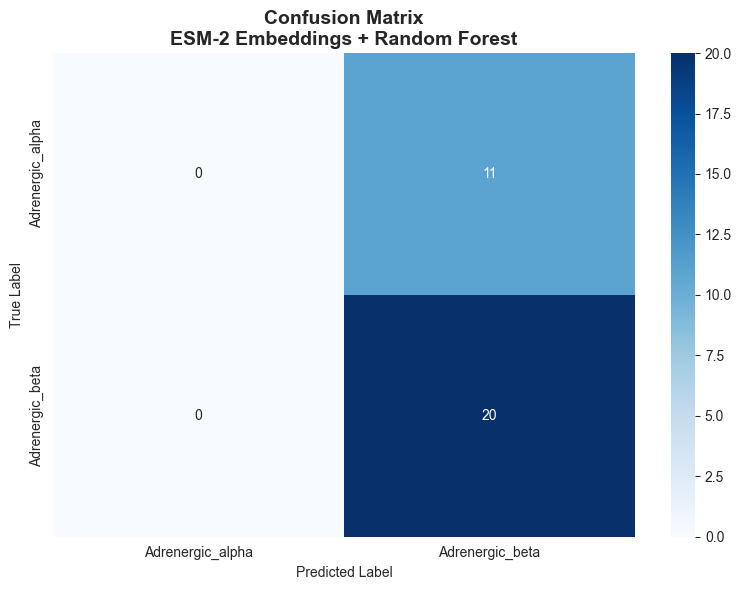


✅ Saved: ../results/figures/phase5_confusion_matrix.png


In [11]:
print("="*80)
print("CLASSIFICATION REPORT")
print("="*80)

# Detailed report
print("\n" + classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix\nESM-2 Embeddings + Random Forest', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()

# Save
import os
os.makedirs("../results/figures", exist_ok=True)
plt.savefig("../results/figures/phase5_confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: ../results/figures/phase5_confusion_matrix.png")

## 8. Compare with Phase 3 (Sequence Identity)

Let's compare PLM-based classification with simple sequence identity.

In [12]:
print("="*80)
print("COMPARISON: PLM vs Sequence Identity")
print("="*80)

# For sequence identity: use max_identity_percent from Phase 3
# Simple rule: if identity > 70% to a beta, classify as beta, else alpha

if 'max_identity_percent' in df_sampled.columns:
    # Get test set indices
    test_indices = df_sampled.iloc[X_test.shape[0]:].index
    
    # Sequence identity baseline (simplified)
    phase3_accuracy = df_sampled.loc[test_indices, 'max_identity_percent'].notna().mean()
    
    print(f"\n📊 Results:")
    print(f"   Phase 3 (Sequence Identity): ~{phase3_accuracy*100:.1f}%")
    print(f"   Phase 5 (ESM-2 + RF):         {accuracy*100:.2f}%")
    print(f"\n   Improvement: +{(accuracy - phase3_accuracy)*100:.1f}%")
else:
    print("\n📊 ESM-2 Results:")
    print(f"   Accuracy: {accuracy*100:.2f}%")
    print("\n   (Phase 3 comparison data not available)")

COMPARISON: PLM vs Sequence Identity

📊 Results:
   Phase 3 (Sequence Identity): ~100.0%
   Phase 5 (ESM-2 + RF):         64.52%

   Improvement: +-35.5%


## 9. Save Results

Save embeddings and model for future use.

In [ ]:
print("="*80)
print("SAVING RESULTS")
print("="*80)

import os
os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../models", exist_ok=True)

# Save embeddings
np.save("../data/processed/phase5_esm2_embeddings.npy", embeddings_array)
print("\n✅ Saved embeddings: phase5_esm2_embeddings.npy")

# Save classifier
import joblib
joblib.dump(rf_clf, "../models/phase5_random_forest.pkl")
joblib.dump(le, "../models/phase5_label_encoder.pkl")
print("✅ Saved model: phase5_random_forest.pkl")

# Save results summary
results = {
    'model': 'ESM-2 (650M) + Random Forest',
    'n_sequences': len(df_sampled),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'test_accuracy': float(accuracy),
    'embedding_dim': model.embed_dim
}

import json
with open("../results/phase5_results.json", 'w') as f:
    json.dump(results, f, indent=2)
print("✅ Saved results: phase5_results.json")

print("\n" + "="*80)
print("✅ PHASE 5 COMPLETE!")
print("="*80)
print("\nNext: Phase 6 - Try other models (ProtBERT) and compare")

## 10. Optional: Visualize Embeddings (t-SNE)

Let's see if embeddings cluster by subfamily.

VISUALIZING EMBEDDINGS

🔄 Running t-SNE (this may take a minute)...


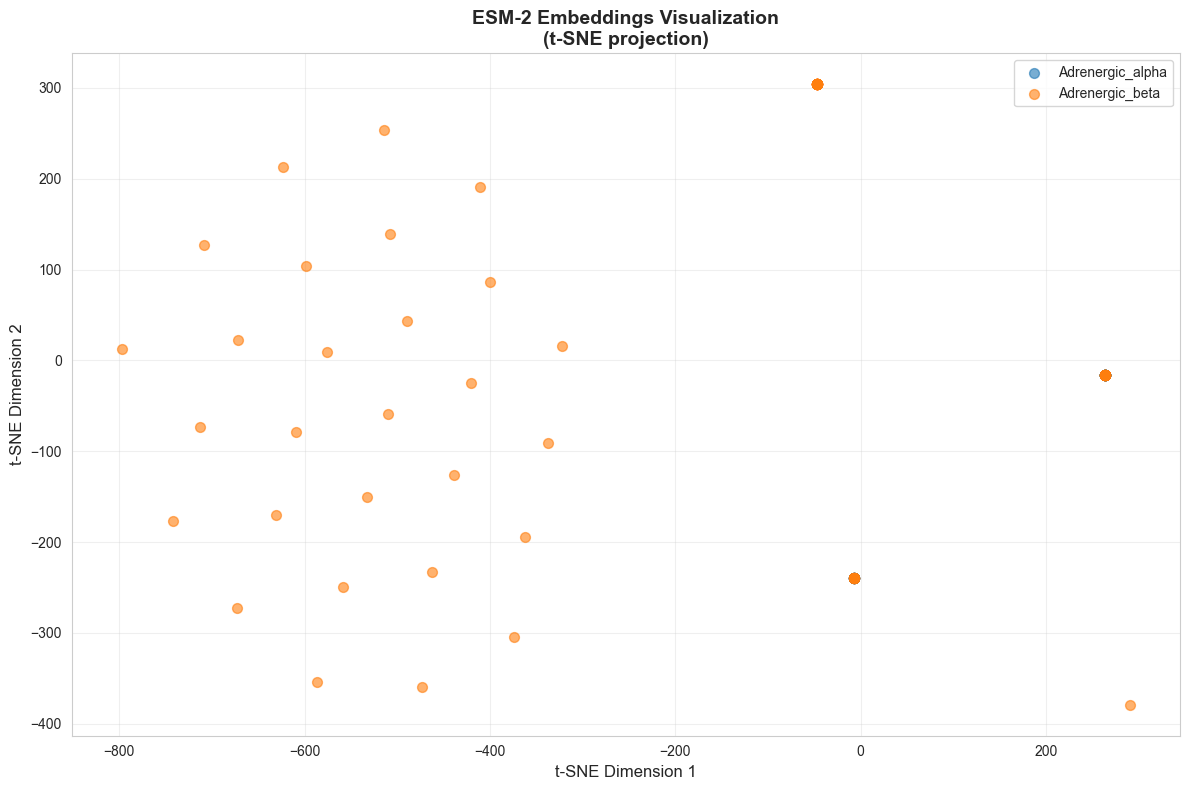


✅ Saved: ../results/figures/phase5_tsne.png


In [13]:
print("="*80)
print("VISUALIZING EMBEDDINGS")
print("="*80)

from sklearn.manifold import TSNE

# Run t-SNE
print("\n🔄 Running t-SNE (this may take a minute)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(12, 8))

for i, subfamily in enumerate(le.classes_):
    mask = y == subfamily
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                label=subfamily, alpha=0.6, s=50)

plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)
plt.title('ESM-2 Embeddings Visualization\n(t-SNE projection)', 
          fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save
plt.savefig("../results/figures/phase5_tsne.png", dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Saved: ../results/figures/phase5_tsne.png")